### Trabalho 1 - Robótica Movel - MO651
#### __Professor(a):__ _Esther Luna Columbini_ <br>
__Alunos:__ <br>
_Tito Barbosa Rezende_              __RA:__ 025327<br>
_João Paulo_                        __RA:__ 229322<br>
_Elcio Pereira de Souza Junior_     __RA:__ 262952

### Pré-requisitos

Instalação das bibliotecas necessárias.

In [2]:
%pip install matplotlib
%pip install numpy
%pip install opencv-python
%pip install sklearn

    Running setup.py install for sklearn: started
    Running setup.py install for sklearn: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


In [45]:
import sys, time
sys.path.insert(0, '../src')
from robot import Robot
import utils
import matplotlib.pyplot as plt
import numpy as np
import vrep
import math
import multiprocessing
import random
from datetime import datetime
import lidar_to_grid_map as lg
import cv2 as cv

### Definindo objeto robô

Nos próximos passos será instanciado o objeto robô, este será utilizado durante todo o projeto. Também serão realizados uma série de testes de conexão com a API.


In [4]:
robot = Robot()

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Left motor connected.
 Right motor connected.
 Robot connected.


## Modelo Cinemático

### Sensor Laser

Nesta etapa definimos a classe para leitura dos dados que serão obtidos pelo sensor laser, e realizamos uma verificação sobre a obtenção destes dados.

In [21]:
class Laser_sensor:
    def __init__(self,robot):
        self.robot = robot

    def update_robot_frame_reading(self):
        laser_flatten_readings = np.array(self.robot.read_laser())
        laser_readings = laser_flatten_readings.reshape((len(laser_flatten_readings)//3, 3))
        self.laser_x = laser_readings[:,0]
        self.laser_y = laser_readings[:,1]

    def plot_laser_robot_frame(self):
#     fig, ax = plt.subplots()
#     #posição dos feixes laser
#     ax.scatter(laser_sensor.laser_x, laser_sensor.laser_y, 3, c='g', marker='o')
#     #posição do centro do robo
#     ax.scatter(0, 0, 40, c='b', marker='o')
#     plt.show()
        ox = self.laser_x
        oy = self.laser_y
        plt.figure(figsize=(6,10))
        plt.plot([oy, np.zeros(np.size(oy))], [ox, np.zeros(np.size(oy))], "ro-") # lines from 0,0 to the 
        plt.axis("equal")
        bottom, top = plt.ylim()  # return the current ylim
        plt.ylim((top, bottom)) # rescale y axis, to match the grid orientation
        plt.grid(True)
        plt.show()
        
    def plot_grid_fill(self):
        xyreso = 0.02  # x-y grid resolution
        #yawreso = math.radians(3.1)  # yaw angle resolution [rad]
        
        ox = self.laser_x
        oy = self.laser_y
        pmap, minx, maxx, miny, maxy, xyreso = lg.generate_ray_casting_grid_map(ox, oy, xyreso, False)
        xyres = np.array(pmap).shape
        plt.figure(figsize=(20,8))
        plt.subplot(122)
        plt.imshow(pmap, cmap = "PiYG_r") 
        plt.clim(-0.4, 1.4)
        plt.gca().set_xticks(np.arange(-.5, xyres[1], 1), minor = True)
        plt.gca().set_yticks(np.arange(-.5, xyres[0], 1), minor = True)
        plt.grid(True, which="minor", color="w", linewidth = .6, alpha = 0.5)
        plt.colorbar()
        plt.show()
         
    
laser_sensor = Laser_sensor(robot)
laser_sensor.update_robot_frame_reading()

Verificação dos dados brutos coletados

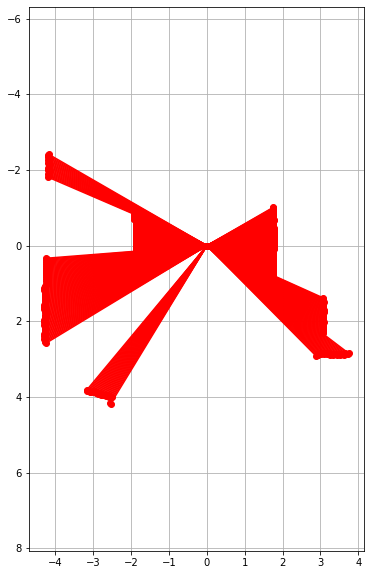

In [22]:
laser_sensor.plot_laser_robot_frame()

The grid map is  500 x 600 .


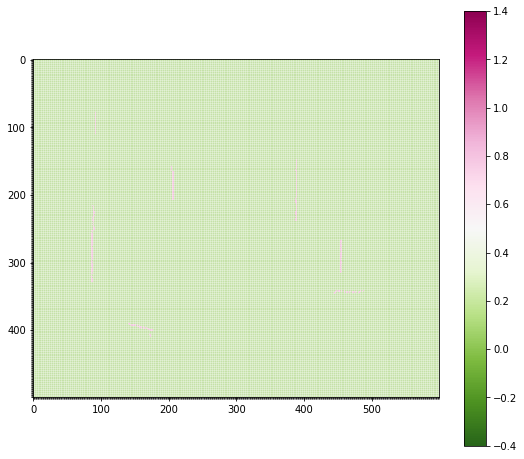

In [23]:
laser_sensor.plot_grid_fill()

Vamos mudar a posição do robo e ler novamente

### Sensor Ultrassônico

Para obter a leitura correta dos sensores de proximidade, precisamos transformar a leitura do sensor em um ponto _(x,y)_ em relação ao frame do robo.


In [24]:
class Us_sensor:
    def __init__(self,robot):
        orientation_angles = np.array([90,50,30,10,-10,-30,-50,-90,-90,-130,-150,-170,170,150,130,90])
        orientation_rad = np.radians(orientation_angles)
        self.data = {
        "prefix" : "Pioneer_p3dx_ultrasonicSensor",
        "ids" : np.arange(1,17,1), "handles" : np.zeros(16, dtype=int), 
        "positions" :  np.zeros((16,3),dtype=float),
        "angles_deg": orientation_angles,
        "angles_rad": orientation_rad,
        "raw_reading": np.zeros(16),
        "robot_frame_reading": np.zeros((16,2),dtype=float)
        }
        self.robot = robot
        
        for i,sensor_i in enumerate(self.data['ids']):
            ret,handle = vrep.simxGetObjectHandle(self.robot.clientID, self.data['prefix'] + str(sensor_i), vrep.simx_opmode_oneshot_wait)
            self.data['handles'][i] = handle
            ret, pos = vrep.simxGetObjectPosition(self.robot.clientID, handle, self.robot.robot_handle, vrep.simx_opmode_oneshot_wait)
            #ret, ang = vrep.simxGetObjectOrientation(robot.clientID, handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
            self.data['positions'][i,:] = pos
            #ultrassonic_sensors[sensor_i,4:7] = ang
    
    def update_raw_reading(self):
        self.data["raw_reading"] = np.array(self.robot.read_ultrassonic_sensors())
    
    def update_robot_frame_reading(self):
        self.update_raw_reading()
        for i, proximity in enumerate(us_sensors.data["raw_reading"]):
            if proximity == 5 or proximity < 0.1:
                self.data["robot_frame_reading"][i] = np.zeros(2)
            else:
                self.data["robot_frame_reading"][i] = self.proximity_robot_frame(i+1,proximity).flatten()
                
        #toRobotFrame = lambda sensorId,proximity: self.proximity_robot_frame(sensorId,proximity)
        #self.data["robot_frame_reading"] = toRobotFrame(range(1,17,1),us_sensors.data["raw_reading"])
    
    #Calcula o ponto no frame do robo, referente a leitura de cada sensor de proximidade
    def proximity_robot_frame(self,sensorId, proximity):
        index = sensorId -1
        angulars = self.data["angles_rad"][index]
        #Matriz de rotação
        rot_matrix = np.array([[math.cos(angulars),-math.sin(angulars)],[math.sin(angulars),math.cos(angulars)]])
        #Rotacionando a leitura
        distXY = np.dot(rot_matrix , np.array([[proximity],[0]]))
        #Matriz de translação
        posicao_sensor_x = self.data["positions"][index][0]
        posicao_sensor_y = self.data["positions"][index][1]
        transXY=np.array([[distXY[0][0]+posicao_sensor_x],[distXY[1][0]+posicao_sensor_y]])
        return transXY
    
    def plot_us_robot_frame(self):
        fig, ax = plt.subplots()
        #posição dos sensores US
        ax.scatter(self.data['positions'][:,0], self.data['positions'][:,1], 10, c='r', marker='o')
        #posição do centro do robo
        ax.scatter(0, 0, 40, c='b', marker='o')
        #posição dos pontos lidos pelo sensor ultrassonico
        ax.scatter(self.data['robot_frame_reading'][:,0], self.data['robot_frame_reading'][:,1], 10, c='black', marker='.')
        plt.show()

us_sensors = Us_sensor(robot)

Definimos uma função _toGlobal_ (para termos um melhor reuso de código), basicamente a função transforma um ponto qualquer _(x,y)_ que esteja na referência do robô e o leva para a referência global.

In [25]:
def toGlobal(robot_x, robot_y,robot_ang, Point_xr, Point_yr):
    T_trans = np.array([[1,0,robot_x],[0,1,robot_y],[0,0,1]])
    T_rot = np.array([[math.cos(robot_ang),-math.sin(robot_ang),0],[math.sin(robot_ang),math.cos(robot_ang),0],[0,0,1]])
    T = np.dot(T_trans,T_rot)
    res = np.dot(T, np.array([Point_xr,Point_yr,1]))
    return res[0],res[1]

## Modelo Cinemático

Dado o movimento do robo, como determinar sua posição e orientação no frame global?

In [26]:
class Kinematic_model:
    def __init__(self,robot):
        self.robot = robot
        
        #Handles dos motores
        ret1, self.motorLeft = vrep.simxGetObjectHandle(self.robot.clientID, "Pioneer_p3dx_leftMotor", vrep.simx_opmode_oneshot_wait)
        ret2, self.motorRight = vrep.simxGetObjectHandle(self.robot.clientID, "Pioneer_p3dx_rightMotor", vrep.simx_opmode_oneshot_wait)
        
        #Calcula distancia de eixo
        res, left_handle = vrep.simxGetObjectHandle(robot.clientID, "Pioneer_p3dx_leftMotor", vrep.simx_opmode_oneshot_wait)
        ret, lpos = vrep.simxGetObjectPosition(robot.clientID, left_handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
        
        res, right_handle = vrep.simxGetObjectHandle(robot.clientID, "Pioneer_p3dx_rightMotor", vrep.simx_opmode_oneshot_wait)
        ret, rpos = vrep.simxGetObjectPosition(robot.clientID, right_handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
        
        # eixo
        self.l = (abs(lpos[1]) + abs(rpos[1]))/2
        
        #Ao ser criado, coleta a referencia de zero do robo
        pos = self.robot.get_current_position()
        self.initial_pos_x = pos[0]
        self.initial_pos_y = pos[1]
        orientation = self.robot.get_current_orientation()
        self.initial_orientation = orientation[2]

        #Alem de mantermos a pose inicial, manteremos a pose atualizada do robo
        self.enc_global_x = self.initial_pos_x
        self.enc_global_y = self.initial_pos_y
        self.enc_Theta = self.initial_orientation
        
        self.time_global_x = self.initial_pos_x
        self.time_global_y = self.initial_pos_y
        self.time_Theta = self.initial_orientation
        
        #Lista de pontos para o caminho do robo
        self.enc_path = []
        self.time_path = []
        self.true_path = []
        self.update_paths()
        
        #inicializando a posição dos encoders
        self.jL = self.current_encoder_left()
        self.jR = self.current_encoder_right()
        
        #intervalo entre cada calculo
        self.compute_interval = 0.1
        self.previous_timestamp = 0
        
    def update_paths(self):
        self.enc_path.append([self.enc_global_x, self.enc_global_y, self.enc_Theta])
        self.time_path.append([self.time_global_x, self.time_global_y, self.time_Theta])
        orientation = self.robot.get_current_orientation()
        true_theta = orientation[2]
        current_position = self.true_global_position()
        self.true_path.append([current_position[0], current_position[1], true_theta])
    
    def true_global_position(self):
        pos = self.robot.get_current_position()
        return pos[0],pos[1]
    
    def enc_global_position(self):
        return self.enc_global_x, self.enc_global_y, self.enc_Theta
    
    def time_global_position(self):
        return self.time_global_x, self.time_global_y, self.time_Theta
    
    
    ##Esta seção esta relacionada ao calculo da posição levando em consideração os encoders
    def current_encoder_left(self):
        ret,jL = vrep.simxGetJointPosition(self.robot.clientID,self.motorLeft,vrep.simx_opmode_oneshot_wait)
        return jL
    def current_encoder_right(self):
        ret, jR = vrep.simxGetJointPosition(self.robot.clientID,self.motorRight,vrep.simx_opmode_oneshot_wait)
        return jR
        
    #Phi speed of rotation of wheels
    def Xr(self, Phi_right, Phi_left):
        r = self.robot.WHEEL_RADIUS
        Xr = (r*Phi_left/2) + (r*Phi_right/2)
        return Xr
    
    def Theta_r(self, Phi_right, Phi_left):
        r = self.robot.WHEEL_RADIUS
        Tr = r*Phi_right/(2*self.l) - r*Phi_left/(2*self.l) 
        return Tr
        
    def speed_model(self,Phi_right,Phi_left):
        #Se formos considerar que o eixo das rodas do robo está deslocado do eixo x
        #return np.array([self.Xr(Phi_right,Phi_left),self.Theta_r(Phi_right,Phi_left)*self.l2,self.Theta_r(Phi_right,Phi_left)])
        return np.array([self.Xr(Phi_right,Phi_left),0,self.Theta_r(Phi_right,Phi_left)])
        
    def inverse_rotation_matrix(self, ang):
        Trot = np.array([[math.cos(ang), -math.sin(ang), 0], [math.sin(ang), math.cos(ang), 0], [0,0,1]])
        return Trot
    
    def locomotion_global(self, ang, Phi_right, Phi_left):
        return np.dot(self.inverse_rotation_matrix(ang),self.speed_model(Phi_right,Phi_left))
    
    def compute_with_encoder(self):
        dxR = self.current_encoder_right() - self.jR
        dxL = self.current_encoder_left() - self.jL
        if (dxL>=0):
            dxL=math.fmod(dxL+math.pi,2*math.pi)-math.pi
        else:
            dxL=math.fmod(dxL-math.pi,2*math.pi)+math.pi
        if (dxR>=0):
            dxR=math.fmod(dxR+math.pi,2*math.pi)-math.pi
        else:
            dxR=math.fmod(dxR-math.pi,2*math.pi)+math.pi
        qsi = self.locomotion_global(self.enc_Theta,dxR, dxL)
        #Atualiza a posição global
        self.enc_global_x = self.enc_global_x + qsi[0]
        self.enc_global_y = self.enc_global_y + qsi[1]
        self.enc_Theta = self.enc_Theta + qsi[2]
        #Atualiza a posição dos encoders
        self.jR = self.current_encoder_right()
        self.jL = self.current_encoder_left()
    ##Fim da seção relacionada ao calculo da posição levando em consideração os encoders        
    
    def compute_with_time(self, Phi_right, Phi_left):
        #Calculo do delta S
        r = self.robot.WHEEL_RADIUS
        Vr = r*Phi_right
        Vl = r*Phi_left
        current_timestamp = datetime.timestamp(datetime.now())
        Delta_t = current_timestamp - self.previous_timestamp
        #atualiza timestamp imediatamente

        self.previous_timestamp = current_timestamp
        
        Delta_s = (Vr + Vl)*Delta_t/2  
        Delta_Theta = (Vr - Vl)*Delta_t/(2*self.l)
    
        self.time_global_x = self.time_global_x + Delta_s*math.cos(self.time_Theta + Delta_Theta/2)
        self.time_global_y = self.time_global_y + Delta_s*math.sin(self.time_Theta + Delta_Theta/2)
        self.time_Theta = self.time_Theta + Delta_Theta
    
    def move(self,Phi_right, Phi_left,seconds): #velocidade em rad/s
        #Vamos fixar um tempo de 500ms para computar as distâncias
        for step in range(int(seconds/self.compute_interval)):
            #self.compute()
            self.robot.set_right_velocity(Phi_right)
            self.robot.set_left_velocity(Phi_left)
            time.sleep(self.compute_interval)
            self.compute_with_encoder()
            self.compute_with_time(Phi_right, Phi_left)
            self.update_paths()
        self.robot.stop()
        self.timestamp = 0
        
    def ICR_left(self, Phi_left, R, seconds):
        Phi_right = Phi_left*(R + self.l)/(R - self.l)
        print("ICR_left Phi_r {} Phi_l {}".format(Phi_right, Phi_left))
        self.move(Phi_right, Phi_left, seconds)
    
    def ICR_right(self, Phi_right, R, seconds):
        Phi_left = Phi_right*(R + self.l)/(R - self.l)
        print("ICR_right Phi_r {} Phi_l {}".format(Phi_right, Phi_left))
        self.move(Phi_right, Phi_left, seconds)
  
    def plot_paths(self):
        enc_path = np.array(self.enc_path)
        time_path = np.array(self.time_path)
        true_path = np.array(self.true_path)
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        ax[0].scatter(enc_path[:,0], enc_path[:,1], 5, c='b', marker='o')
        #ax[1].scatter(time_path[:,0], time_path[:,1], 5, c='g', marker='o')
        ax[1].scatter(true_path[:,0], true_path[:,1], 5, c='r', marker='o')

Para esta implementação, o grupo se baseou nas técnicas discutidas em sala de aula.

## Nuvem de pontos

Para a nuvem de pontos, nós coletamos os dados fornecidos pelo laser (conjunto de pontos) que estão baseados no sistema de referência do robô, após aplicamos a transformação destes pontos para o sistema de referência global. Dados os pontos no sistema global nós realizamos a plotagem dos mesmos.

In [347]:
class PointCloud():
    def __init__(self, robot, us_sensors, laser_sensor):
        self.robot = robot
        self.us_sensors = us_sensors
        self.laser_sensor = laser_sensor
        self.res = 0.05
        
        self.ultrassonic_points = []
        self.laser_points = []
        self.robot_points = []
    
    def update(self):
        #Insere posição atual do robo
        robot_x = self.robot.get_current_position()[0]
        robot_y = self.robot.get_current_position()[1]
        robot_ang = self.robot.get_current_orientation()[2]
        
        self.robot_points.append([robot_x,robot_y])

        #Atualiza a leitura do laser e insere na nuvem de pontos
        self.laser_sensor.update_robot_frame_reading()
        for pointx, pointy in zip(self.laser_sensor.laser_x, self.laser_sensor.laser_y):
            x,y = toGlobal(robot_x, robot_y,robot_ang, pointx, pointy)
            self.laser_points.append([x,y])

        #Atualiza a leitura do ultrassonico e insere na nuvem de pontos
        self.us_sensors.update_robot_frame_reading()
        for pointx, pointy in zip(self.us_sensors.data['robot_frame_reading'][:,0], self.us_sensors.data['robot_frame_reading'][:,1]):
            x,y = toGlobal(robot_x, robot_y,robot_ang, pointx, pointy)
            self.ultrassonic_points.append([x,y])
    
    def plot_point_cloud(self):
        #Convertendo a nuvem de pontos em um array
        ultrassonic_point_array = np.array(self.ultrassonic_points)
        laser_point_array = np.array(self.laser_points)
        robot_path = np.array(self.robot_points)
        ax = plt.axes([0,0,1,1], frameon=False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ###fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
        #posição do centro do robo
        ###ax[0].scatter(robot_path[:,0], robot_path[:,1], 40, c='b', marker='o')
        #ax[0].plot(robot_path[:,0], robot_path[:,1],'.-')
        pass_count = 0
        for x, y in zip(robot_path[:,0], robot_path[:,1]):
            ###ax[0].text(x, y, str(pass_count), color="black", fontsize=12)
            pass_count += 1
        #posição dos pontos lidos pelo sensor ultrassonico
        ###ax[0].scatter(ultrassonic_point_array[:,0],ultrassonic_point_array[:,1], 10, c='magenta', marker='.')


        #posição do centro do robo
        ###ax.scatter(robot_path[:,0], robot_path[:,1], 40, c='b', marker='o')
        #ax[1].plot(robot_path[:,0], robot_path[:,1],'.-')
        pass_count = 0
        for x, y in zip(robot_path[:,0], robot_path[:,1]):
            ###ax.text(x, y, str(pass_count), color="black", fontsize=12)
            pass_count += 1
        #posição dos pontos lidos pelo sensor laser
        ax.scatter(laser_point_array[:,0],laser_point_array[:,1], 10, c='r', marker='.')
        
        #plt.autoscale(tight=True)
        fig1 = plt.gcf()
        plt.show()
        fig1.savefig('pointcloud_map.png')
          
    def set_resolution(self, resolution):
        self.res = resolution
        
    def plot_grid_ocupation(self):
        xyreso = self.res  # x-y grid resolution
        #yawreso = math.radians(3.1)  # yaw angle resolution [rad]
        #ang, dist = file_read("lidar01.csv")
        laser_point_array = np.array(self.laser_points)
        ox = laser_point_array[:,0]
        oy = laser_point_array[:,1]
        pmap, minx, maxx, miny, maxy, xyreso = lg.generate_ray_casting_grid_map(ox, oy, xyreso, False)
        xyres = np.array(pmap).shape
        plt.figure(figsize=(20,8))
        ###plt.subplot(122)
        ###plt.imshow(pmap, cmap = "PiYG_r") 
         
        """plt.clim(-0.4, 1.4)
        plt.gca().set_xticks(np.arange(-.5, xyres[1], 1), minor = True)
        plt.gca().set_yticks(np.arange(-.5, xyres[0], 1), minor = True)
        plt.grid(True, which="minor", color="w", linewidth = .6, alpha = 0.5)"""
        ax = plt.axes([0,0,1,1], frameon=False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.imshow(pmap, cmap = "PiYG_r")
        #plt.colorbar()
        fig1 = plt.gcf()
        plt.show()
        fig1.savefig('graph_map.png')
    
        

point_cloud = PointCloud(robot, us_sensors, laser_sensor)

In [348]:
np.array(point_cloud.laser_points).shape

(0,)

#### PASSO 1:
Atualiza o buffer da nuvem de pontos.

In [349]:
point_cloud.update()

#### PASSO 2:
Exibe o atual status da nuvem de pontos.

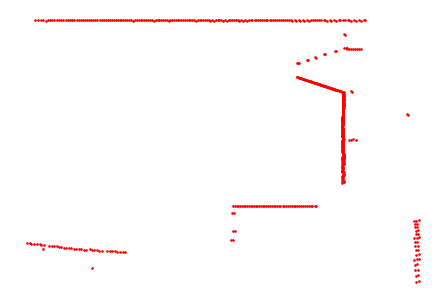

In [350]:
point_cloud.plot_point_cloud()

In [110]:
point_cloud.get_clustered_points()

AttributeError: 'PointCloud' object has no attribute 'get_clustered_points'

In [111]:
point_cloud.clustering

AttributeError: 'PointCloud' object has no attribute 'clustering'

The grid map is  160 x 220 .


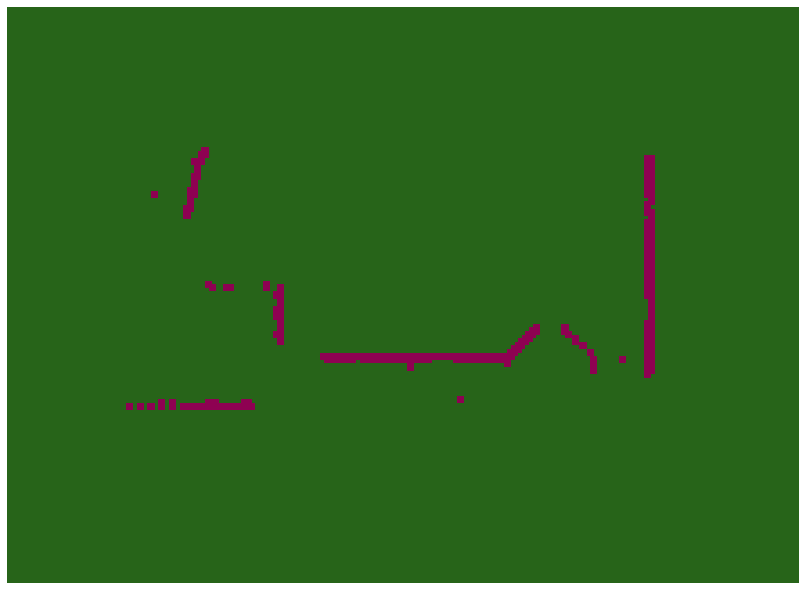

In [351]:
point_cloud.plot_grid_ocupation()

O primeiro (mais a esquerda do monitor) e o segundo gráfico exibem a posição do robô em um determinado tempo no ambiente, porém o primeiro exibe somente os pontos vistos pelo sensor ultrassônico, enquanto o segundo exibe os pontos vistos pelo laser. Esta plotagem favorece a comparação do volume de dados que está sendo gerado por ambos os sensores.

#### PASSO 3:
Move o robô para uma nova posição para que possamos verificar a alteração na nuvem de pontos.

In [34]:
#Passo 3

#Move o robo
robot.set_right_velocity(3)
robot.set_left_velocity(4)
time.sleep(10)
robot.stop()

__OBS:__ Visto que estamos utilizando um Jupyter Notebook para apresentação do código, execute repetidas vezes os passos 1, 2 e 3, simulando o movimento do robo adquirindo informações.
Em uma situação real, os processos de coleta, movimento e odometria executariam em threads separadas.

## Encapsulamento
A classe a seguir encapsula todos os modelos criados anteriormente.

In [352]:
class MobileRobot():
    def __init__(self):
        self.robot = Robot()
        self.kinematicModel = Kinematic_model(self.robot)
        self.us_sensors = Us_sensor(self.robot)
        self.laser_sensors = Laser_sensor(self.robot)
        self.point_cloud = PointCloud(self.robot, self.us_sensors, self.laser_sensors)
        
        self.point_cloud.update()
    
        self.compute_interval = 0.5
        
        self.braitenbergL=[-0.2,-0.4,-0.6,-0.8,-1.0,-1.2,-1.4,-1.6]
        self.braitenbergR=[-1.6,-1.4,-1.2,-1.0,-0.8,-0.6,-0.4,-0.2]

        self.detect = [0,0,0,0,0,0,0,0]
        self.noDetectionDist = 1.0
        self.maxDetectionDist = 0.2
        
    def braitenberg(self, dist, vel):
        vLeft = vRight = vel
        for i in range(len(dist)):
            if(dist[i] < self.noDetectionDist):
                self.detect[i] = 1 - ((dist[i]-self.maxDetectionDist)/(self.noDetectionDist-self.maxDetectionDist))
            else:
                self.detect[i]=0
            for i in range(8):
                vLeft = vLeft + self.braitenbergL[i]*self.detect[i]
                vRight = vRight+ self.braitenbergR[i]*self.detect[i]
                
        return [vLeft, vRight]

    def start_braitenberg(self, seconds):
        for step in range(int(seconds/self.compute_interval)):
            Phi_l, Phi_r = self.braitenberg(self.us_sensors.data["raw_reading"][:8],2)
            self.kinematicModel.move(Phi_r, Phi_l,self.compute_interval)
            #self.kinematicModel.plot_paths()
            self.point_cloud.update()
            #self.point_cloud.plot_point_cloud()

In [355]:
mr = MobileRobot()

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Left motor connected.
 Right motor connected.
 Robot connected.


In [357]:
mr.start_braitenberg(50)

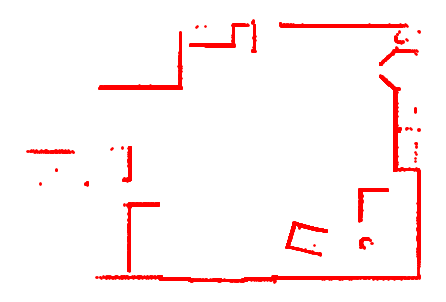

In [358]:
mr.point_cloud.plot_point_cloud()

In [423]:
mr.point_cloud.set_resolution(0.1)

The grid map is  160 x 120 .


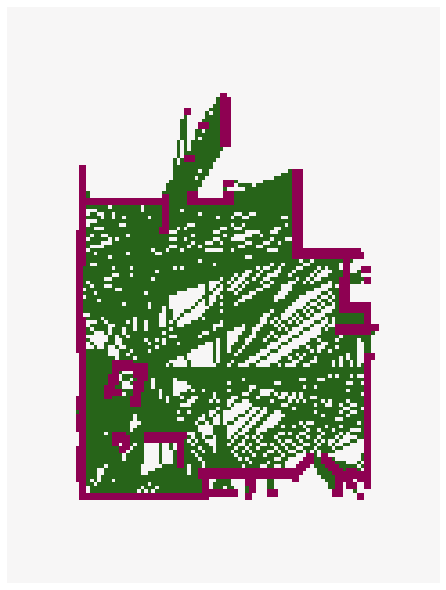

In [424]:
mr.point_cloud.plot_grid_ocupation()

[array([[[717,  86]],

       [[717,  89]],

       [[716,  90]],

       [[713,  90]],

       [[713,  96]],

       [[712,  97]],

       [[710,  97]],

       [[710, 100]],

       [[709, 101]],

       [[706, 101]],

       [[706, 103]],

       [[705, 104]],

       [[702, 104]],

       [[702, 111]],

       [[701, 112]],

       [[699, 112]],

       [[699, 114]],

       [[698, 115]],

       [[695, 115]],

       [[695, 121]],

       [[694, 122]],

       [[692, 122]],

       [[692, 132]],

       [[691, 133]],

       [[688, 133]],

       [[688, 143]],

       [[687, 144]],

       [[684, 144]],

       [[683, 143]],

       [[683, 108]],

       [[684, 107]],

       [[687, 107]],

       [[687, 101]],

       [[681, 101]],

       [[681, 111]],

       [[680, 112]],

       [[677, 112]],

       [[677, 132]],

       [[676, 133]],

       [[674, 133]],

       [[674, 150]],

       [[673, 151]],

       [[670, 151]],

       [[670, 172]],

       [[669, 173]],

       [[

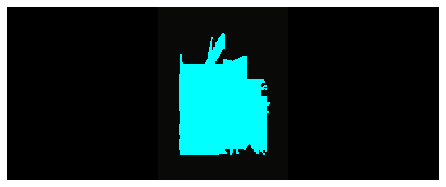

In [445]:
img = cv.imread('graph_map.png')
img = cv.bitwise_not(img)
imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

ret, thresh = cv.threshold(imgray, 76, 255, cv.THRESH_BINARY)
contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)


im3 = cv.fillPoly(img,contours,(0,255,255))
ax = plt.axes([0,0,1,1], frameon=False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(img)
plt.show
print(contours)

In [525]:
import SweepSearcher as ss

Done
Start point:  [129, 0]


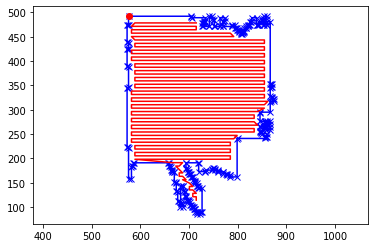

In [532]:
ox = []
oy = []
reso = 7.0
moving_direction=ss.SweepSearcher.MovingDirection.RIGHT
sweeping_direction=ss.SweepSearcher.SweepDirection.UP

for sublist in contours:
    for item in sublist:
        for point in item:
            ox.append(point[0])
            oy.append(point[1])

sweep_vec, sweep_start_posi = ss.find_sweep_direction_and_start_posi(ox, oy)
rox, roy = ss.convert_grid_coordinate(ox, oy, sweep_vec, sweep_start_posi)
gmap, xinds_goaly, goaly = ss.setup_grid_map(rox, roy, reso, sweeping_direction)
sweep_searcher = ss.SweepSearcher(moving_direction, sweeping_direction, xinds_goaly, goaly)
px, py = ss.sweep_path_search(sweep_searcher, gmap)
rx, ry = ss.convert_global_coordinate(px, py, sweep_vec, sweep_start_posi)

plt.cla()
plt.plot(ox, oy, "-xb")
plt.plot(rx, ry, "-r")
plt.plot(sweep_start_posi[0],sweep_start_posi[1],"or")
print("Start point: ",sweep_vec)

## Conclusão

<br>
Para o projeto ultilizamos os seguintes sensores:

* Encoders
* Sensores Ultrassônicos
* Laser Hokuyo
* Câmera
<br><br>
<div style="text-align: justify">
Os encoders foram utilizados para o processo de odometria, com os dados fornecidos por eles nós estimamos o deslocamento realizado pelo robô no ambiente. Já os sensores ultrassônicos utilizamos para detectar objetos que estivessem mais próximos do robô devido seu curto alcance, porém focamos na utilização do laser para criação da nuvem de pontos por apresentar uma maior precisão e alcance. A utilização da câmera durante o processo foi especificamente para depuração do código, durante a construção do mesmo utilizamos ela para ter uma melhor visão do que estava sendo observado pelo robô.
Como mencionado anteriormente os dados obtidos durante a coleta apresentam algumas variações em relação aos dados reais fornecidos pelo simulador V-REP (variações visíveis na odometria), estas variações são mais perceptíveis quando principalmente o robô realiza mudanças de direção, acreditamos que isto deve ocorrer pelo fato da imprecisão dos sensores (neste caso o encoder), o que gera um erro durante os cálculos de estimação de posição, tendo assim um acúmulo de erros durante todo o processo. Uma alternativa para a correção deste erro é a de utilização dos dados do laser como alternativa para minimização destes erros, onde poderíamos pegar pontos de referência na nuvem de pontos para calcularmos os ângulos de rotação e o deslocamento, porém o aperfeiçoamento deste modelo deve ser realizado somente na próxima etapa do trabalho.
</div>